In [2]:
%pylab inline
%matplotlib inline
from cometprops import *
import rebound, rebound.data


Populating the interactive namespace from numpy and matplotlib


# Rebound initialization

In [6]:
#np.random.seed(560)


def run_sim(ap):
    sim            = rebound.Simulation()
    sim.units      = ('yr', 'AU', 'Msun')
    
    #integrator options
    sim.integrator = "mercurius"
    sim.dt         = 1e-5
    sim.testparticle_type = 0

    #collision and boundary options
    sim.collision  = "direct"
    sim.collision_resolve = "merge"
    sim.collision_resolve_keep_sorted = 1
    sim.boundary   = "open"
    boxsize        = 1000.
    sim.configure_box(boxsize)
    sim.track_energy_offset = 0
    return sim




## System parameters

In [ ]:
au        = 149597870700    #m 
yr        = 365.5*24*60*60  #s

r_neptune = 24622000/au     #
r_jupiter = 69911000/au     #
r_comet   = 20000/au        #


In [15]:
#massive bodies
tmax = 50
ap   = 0.01  #au
ep   = 0.0
ip   = 0.0

#
sim=run_sim(ap)
sim.add(m=1., r=0.005)              # Sun

case="jupiter"
if case=='jupiter':
    sim.add(m=1e-3,r=r_jupiter,a=ap)  # Neptune
if case == "neptune":
    sim.add(m=5e-5,r=r_neptune,a=ap)  # Neptune

sim.N_active = sim.N
sim.units
r_neptune
r_comet

1.336917424453689e-07

In [16]:
Msun = 1.9e30  #kg
Mjup = 1.898e27 #kg

rho_comet =  600 #kg/m3
rho_plan  = 1330

m_comet = 1e-15 * Msun

RL  = Roche_limit(rho_plan,rho_comet,r_jupiter*au)
HR  = Hill_radius(ap*au,Mjup,Msun)

print(f"Roche limit: {RL} m, Hill Radius {HR} m")
print(f"Roche limit: {RL/(r_jupiter*au)} Rj, Hill Radius {HR/(r_jupiter*au)} Rj")


Roche limit: 222417422.78423607 m, Hill Radius 1036889626.2433069 m
Roche limit: 3.181436723609104 Rj, Hill Radius 14.831566223388407 Rj


In [21]:
# semi-active bodies
n_comets = 1000
q        = 8*ap + 0.02*ap*np.random.random(n_comets)-0.01
e        = np.random.random(n_comets)*0.1
inc      = np.random.normal(0,np.pi,n_comets) 
m        = np.zeros(n_comets)#1e-15 + np.random.random(n_comets) * 1e-15
r        = CometRadius(r_comet,n_comets) 
randf    =  np.random.normal(np.pi,0.01,n_comets) 

a=q/(1-e)

for i in xrange(0,n_comets):
    rand = np.random.random()*2*np.pi
    sim.add(m=m[i], r=r[i], a=a[i], e=e[i], inc=inc[i], Omega=rand, pomega=rand, f=np.pi)
sim.move_to_com()

#the initial periods of the comets
periods=np.zeros(n_comets)
for i in range(2,n_comets+2):
    periods[i-2]=sim.particles[i].P
    
q=a*(1-e)


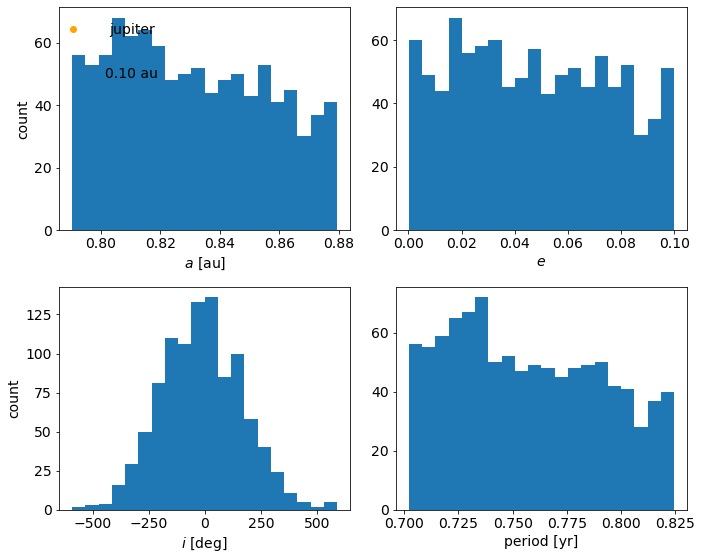

In [63]:
plt.rcParams['font.size'] = '14'

nb=20

plt.figure(figsize=(10,8))

ax1=plt.subplot(221)
ax1.hist(a, bins=nb)
ax2=plt.subplot(222)
ax2.hist(e, bins=nb)
ax3=plt.subplot(223)
ax3.hist(inc*180/np.pi, bins=nb)
ax4=plt.subplot(224)
ax4.hist(periods, bins=nb)

ax1.set_xlabel("$a$ [au]")
ax1.set_ylabel("count")
ax2.set_xlabel("$e$")
ax3.set_xlabel("$i$ [deg]")
ax3.set_ylabel("count")
ax4.set_xlabel("period [yr]")

ax1.text(0.25,0.9,case,ha="center",va="center",transform=ax1.transAxes)
ax1.scatter(0.05,0.9, color= "orange", transform=ax1.transAxes)
ax1.text(0.25,0.7,r"%.2f au"%(ap),ha="center",va="center",transform=ax1.transAxes)

plt.tight_layout()
plt.savefig("./figures/com_prop%d%s.png"%(int(ap),case), dpi=250, facecolor="w")


In [64]:
q.min() - ap

0.6900004542759008

In [65]:
E0 = sim.calculate_energy()

In [66]:

N_out=10000
times = np.linspace(0.,tmax,N_out)

npart=n_comets+2
x     = np.zeros((n_comets+2,N_out))
y     = np.zeros((n_comets+2,N_out))
z     = np.zeros((n_comets+2,N_out))

vx    = np.zeros((n_comets+2,N_out))
vy    = np.zeros((n_comets+2,N_out))
vz    = np.zeros((n_comets+2,N_out))

ecc   = np.zeros((n_comets+2,N_out))
longi = np.zeros((n_comets+2,N_out))
varpi = np.zeros((n_comets+2,N_out))
semi  = np.zeros((n_comets+2,N_out))
incl  = np.zeros((n_comets+2,N_out))
Q     = np.zeros((n_comets+2,N_out))
q     = np.zeros((n_comets+2,N_out))
ps    = sim.particles

In [67]:
collided = []

for i,time in enumerate(times):
    try:
        sim.integrate(time)    
    except rebound.Collision:
        collided = []
    
        for p in sim.particles:
            if p.lastcollision == sim.t:
                collided.append(p.index)
    # Custom resolution
    os = sim.calculate_orbits()

    for j in range(sim.N-1):
        x[j][i]     = ps[j].x;         y[j][i]     = ps[j].y ;         z[j][i]     = ps[j].z
        vx[j][i]    = ps[j].vx;       vy[j][i]     = ps[j].vy;         vz[j][i]    = ps[j].vz
        
        ecc[j][i]   = os[j].e; semi[j][i]  = os[j].a; incl[j][i]  = os[j].inc
        longi[j][i] = os[j].l; varpi[j][i] = os[j].Omega + os[j].omega
        q[j][i]=semi[j][i]*(1-ecc[j][i])
        Q[j][i]=semi[j][i]*(1+ecc[j][i])        
print("Particles {0} collided".format(collided))
        

Particles [] collided


In [68]:
dE = abs((sim.calculate_energy() - E0)/E0)
print(dE)

2.8278018388387215e-13


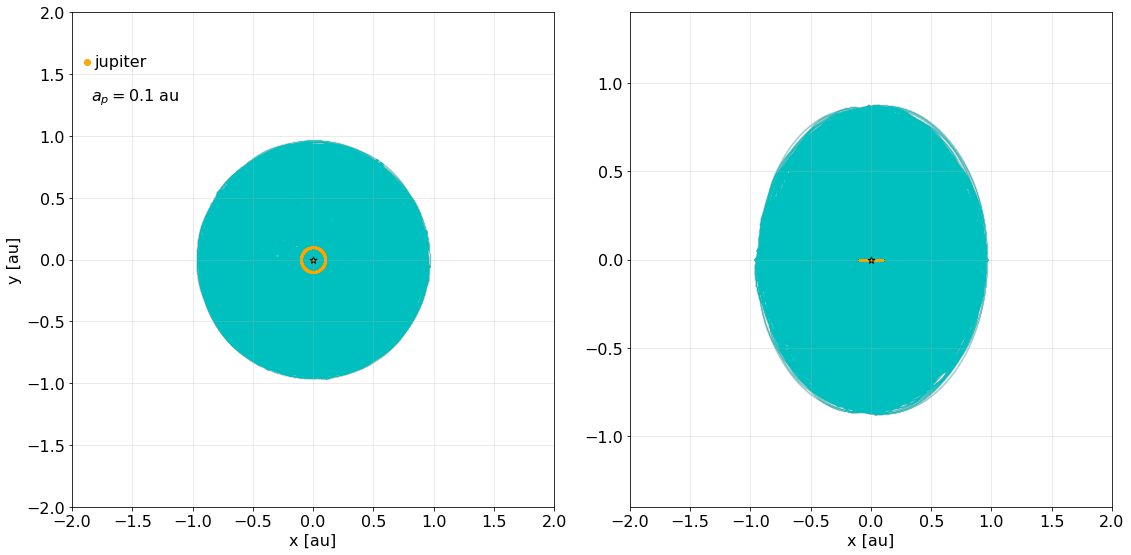

In [71]:
plt.rcParams['font.size'] = '16'

lim = 2
plt.figure(figsize=(16,8))
ax=plt.subplot(121)
plt.scatter(x[2:],y[2:],s=0.02, alpha=0.1, color="c")
plt.scatter(0,0,marker="*", s=50, color="y", ec="k")
plt.scatter(x[1],y[1],s=0.5, color="orange")
#plt.scatter(x[3],y[3],s=1)
#plt.scatter(x[1][1:-1],y[1][1:-1],s=1)
plt.xlabel("x [au]")
plt.ylabel("y [au]")

plt.xlim(-lim,lim)
plt.ylim(-lim,lim)

plt.text(0.1,0.9,case,ha="center",va="center",transform=ax.transAxes)
plt.scatter(0.03,0.9, color= "orange", transform=ax.transAxes)
plt.text(0.13,0.83,r"$a_p=$%.1f au"%(ap),ha="center",va="center",transform=ax.transAxes)
plt.grid(alpha=0.3)

plt.subplot(122)
plt.scatter(x,z,s=0.02, color="c", alpha=0.1)
plt.scatter(x[1],z[1],s=0.2, color="orange")
plt.ylim(-0.7*lim,0.7*lim)
plt.scatter(0,0,marker="*", s=50, color="y", ec="k")
plt.grid(alpha=0.3)

plt.xlim(-lim,lim)
plt.xlabel("x [au]")
plt.tight_layout()
plt.savefig("./figures/scatter%d%s.png"%(int(ap),case), dpi=250, facecolor="w")

In [72]:
fperiods=np.array([])
for i in range(2,sim.N):
    fperiods=np.append(fperiods,sim.particles[i].P)


In [73]:
periods, fperiods
print("yes", len (periods), len (fperiods),n_comets)
if len (periods) ==  len (fperiods):
    print("yes", len (periods), len (fperiods))
    dp=(fperiods-periods)/periods*100
    #print("dif percentual: \n", dp)
    dp2=(fperiods-periods)
else: 
    periods=periods[:-1]
    n_comets=n_comets-1
print("yes", len (periods), len (fperiods), n_comets)

yes 1000 1000 1000
yes 1000 1000
yes 1000 1000 1000


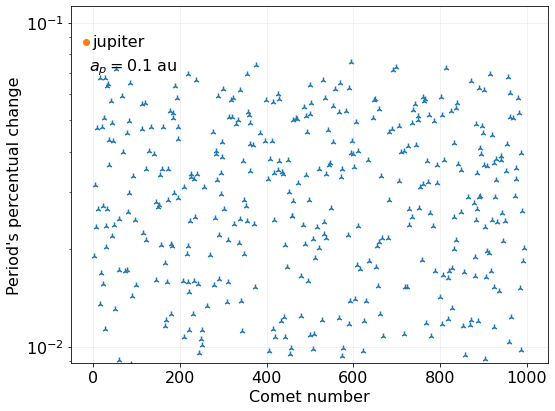

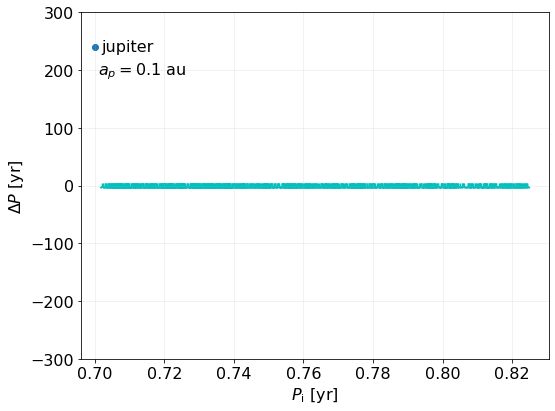

In [74]:


plt.figure(figsize=(8,6))
ax=subplot(111)
plt.scatter(range(n_comets),dp, marker="2")
#plt.plot(range(n_comets),dp, lw=0.3, color="c" )
plt.xlabel("Comet number")
plt.ylabel("Period's percentual change")
plt.grid(alpha=0.2)
plt.text(0.1,0.9,case,ha="center",va="center",transform=ax.transAxes)
plt.scatter(0.03,0.9,transform=ax.transAxes)
plt.text(0.13,0.83,r"$a_p=$%.1f au"%(ap),ha="center",va="center",transform=ax.transAxes)
plt.yscale("log")

#plt.ylim(-300,300)
plt.tight_layout()
plt.savefig("./figures/dperiod%d%s.png"%(int(ap),case), dpi=250, facecolor="w")



plt.figure(figsize=(8,6))
ax=subplot(111)
plt.scatter(periods,dp2, marker="2", color="c")
plt.xlabel("$P_\mathrm{i}$ [yr]")
plt.ylabel(r"$\Delta P$ [yr]")
plt.grid(alpha=0.2)
plt.text(0.1,0.9,case,ha="center",va="center",transform=ax.transAxes)
plt.scatter(0.03,0.9,transform=ax.transAxes)
plt.text(0.13,0.83,r"$a_p=$%.1f au"%(ap),ha="center",va="center",transform=ax.transAxes)
plt.ylim(-300,300)
#plt.yscale("log")
plt.tight_layout()
plt.savefig("./figures/pvsp%d%s.png"%(int(ap),case), dpi=250, facecolor="w")




In [75]:
#np.where(dp==max(dp))[0][0]
ind=np.where(dp==min(dp))[0][0]
#slc=dp[3:]
#ind=np.where(slc==min(slc))[0][0]

#dp[ind]
periods[ind], fperiods[ind]

#ind=20
#ind=16
sim.units

{'length': 'au', 'mass': 'msun', 'time': 'yr'}

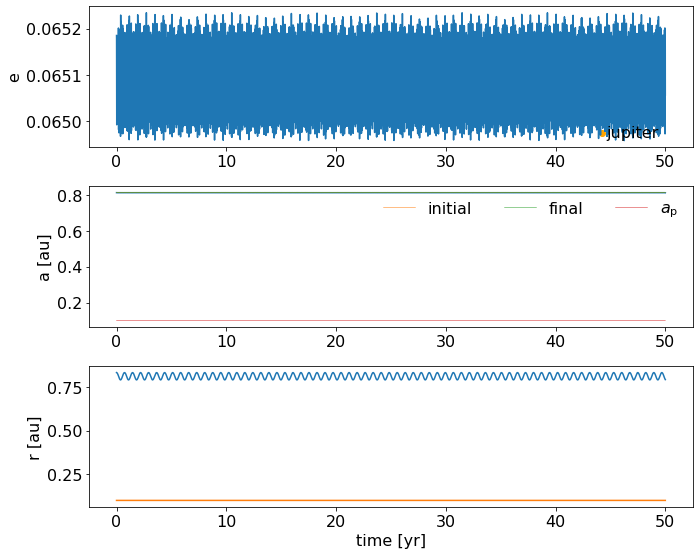

In [76]:
plt.figure(figsize=(10,8))
ax1=plt.subplot(311)
ax1.plot(times,ecc[ind])
ax1.set_ylabel("e")
plt.text(0.9,0.1,case,ha="center",va="center",transform=ax1.transAxes)
plt.scatter(0.85,0.1, color= "orange", transform=ax1.transAxes)
#plt.text(0.13,0.83,r"$a_p=$%.1f au"%(ap),ha="center",va="center",transform=ax.transAxes)

ax2=plt.subplot(312)
ax2.plot(times,semi[ind+1])
#ax2.plot(times, np.ones(len(semi[ind+2])) *np.mean(semi[ind+2]),lw=0.2, label = "average")
ax2.plot(times, np.ones(len(semi[ind+1])) *semi[ind+1][0], lw=0.5, label = "initial")
ax2.plot(times, np.ones(len(semi[ind+1])) *semi[ind+1][-1], lw=0.5, label = "final")
ax2.plot(times, ap*np.ones(len(semi[ind+1])), lw=0.5, label = "$a_\mathrm{p}$")

ax2.set_ylabel("a [au]"), 
plt.legend(ncol=3, framealpha=0)


ax3=plt.subplot(313)
ax3.plot(times,np.sqrt(x[ind+2]**2+y[ind+2]**2+z[ind+2]**2))
ax3.plot(times,np.sqrt(x[1]**2+y[1]**2+z[1]**2))

ax3.set_xlabel("time [yr]")
ax3.set_ylabel("r [au]")
plt.tight_layout()
plt.savefig("./figures/els%d%s.png"%(int(ap),case), dpi=250, facecolor="w")


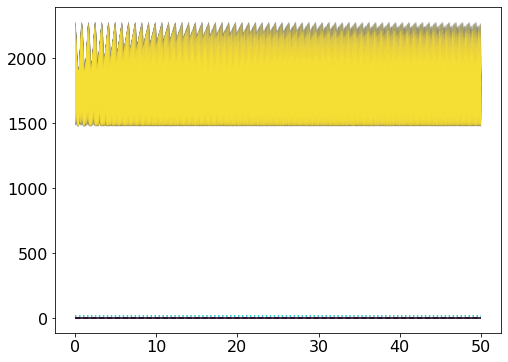

In [81]:
#Distance from planet:


r2p = ((x[2:]-x[1])**2 + (y[2:]-y[1])**2 + (z[2:]-z[1])**2)**0.5

plt.figure(figsize=(8,6))
ax=subplot(111)

c=cm.cividis(linspace(0,1,n_comets,))
for j in range(n_comets):
    ax.plot(times, r2p[j]/(r_jupiter), color=c[j], alpha=0.1, lw=0.2)
ax.hlines(HR/(r_jupiter*au),0,tmax, color="c", linestyle="dotted")
ax.hlines(RL/(r_jupiter*au),0,tmax, color="m", linestyle="dashed")
ax.hlines(1,0,tmax, color="k", linestyle="solid")

#yscale("log")
#ylim(-5,100)
    

In [ ]:
"""colores=cm.jet(np.linspace(0,1,n_comets))
figure()
fig=rebound.OrbitPlot(sim,Narc=800,lw=0.1, fancy=False,  unitlabel="[au]", orbit_type="trail", color=True, slices=0)
ax1=subplot()
ax1.grid(alpha=0.2)
circle1 = plt.Circle((0, 0), ap, fill=False, edgecolor='g', lw=3, clip_on=False)
ax1.add_patch(circle1)
plt.tight_layout()

plt.savefig("./figures/comets.png", dpi=250,facecolor="w")"""

In [ ]:
for i in range(1,n_comets):
    plt.plot(times,ecc[i])


In [17]:
plt.close("all")